In [1]:
import os

os.environ["JAX_ENABLE_X64"] = "true"     
os.environ["JAX_PLATFORMS"] = "cuda"       

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

print("x64 enabled:", config.read("jax_enable_x64"))
print("default dtype:", jnp.ones(()).dtype)
print("devices:", jax.devices())

x64 enabled: True
default dtype: float64
devices: [CudaDevice(id=0), CudaDevice(id=1)]


In [2]:
import os, sys
os.chdir("/home/agnes/Skyclean")       # repo root
sys.path.insert(0, os.getcwd())

from skyclean.silc.ilc import ProduceSILC
from skyclean.silc.ilc import SILCTools
from skyclean.silc.file_templates import FileTemplates
from skyclean.silc.pipeline import Pipeline
from skyclean.silc.power_spec import MapAlmConverter, PowerSpectrumTT
from skyclean.silc.map_tools import SamplingConverters  
from skyclean.silc.download import DownloadData

In [3]:
directory = "/Scratch/agnes/data" 
ft = FileTemplates(directory).file_templates

# INPUT wavelet coeff template (uses {comp}, {frequency}, {scale}, {realisation:05d}, {lmax}, {lam})
file_template = ft.get("wavelet_coeffs") or ft["wavelet_c_j"]

# OUTPUT templates expected by ILC_wav_coeff_maps_MP (use {component}, {extract_comp}, {realisation})
output_templates = {
    "doubled_maps":           ft["doubled_maps"],
    "covariance_matrices":    ft["covariance_matrices"],
    "weight_vector_matrices": ft["weight_vector_matrices"],
    "ilc_maps":               ft["ilc_maps"],
    "trimmed_maps":           ft["trimmed_maps"],
    "ilc_synth":              ft["ilc_synth"],
    "ilc_spectrum":           ft.get("ilc_spectrum"),  
    "scaling_coeffs":         ft["scaling_coeffs"], 
}

In [4]:
pipe = Pipeline(
    components=["cmb","sync","noise","tsz"],
    wavelet_components=["cfn"],
    ilc_components=["cmb"],
    frequencies=["030","044","070","100","143","217","353","545","857"],
    realisations=1,
    start_realisation=0,
    lmax=256,
    N_directions=1,
    lam=2.0,
    method="jax_cuda",
    visualise=True,
    save_ilc_intermediates=False,
    overwrite=False,
    directory="/Scratch/agnes/data",
    constraint=True,
)

In [5]:
pipe.step_download()

--- STARTING DATA DOWNLOAD ---
File /Scratch/agnes/data/CMB_realisations/sync_f030.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f044.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f070.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f100.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f143.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f217.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f353.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f545.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f857.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f030.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f044

In [6]:
pipe.step_process()

--- PROCESSING CFNs AND TOTAL MAP CFN ---
CFN map at 030 GHz for realisation 0 already exists. Skipping processing.
CFN map at 044 GHz for realisation 0 already exists. Skipping processing.
CFN map at 070 GHz for realisation 0 already exists. Skipping processing.
CFN map at 100 GHz for realisation 0 already exists. Skipping processing.
CFN map at 143 GHz for realisation 0 already exists. Skipping processing.
CFN map at 217 GHz for realisation 0 already exists. Skipping processing.
CFN map at 353 GHz for realisation 0 already exists. Skipping processing.
CFN map at 545 GHz for realisation 0 already exists. Skipping processing.
CFN map at 857 GHz for realisation 0 already exists. Skipping processing.


In [7]:
pipe.step_wavelets()

--- PRODUCING WAVELET TRANSFORMS ---
Wavelet coefficients for cfn at 030 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 030 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 044 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 044 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 070 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 070 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 100 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 100 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 143 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 143 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 217 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 217 GHz for realisation 0 saved.
Wavelet coefficients for cf

--- RUNNING ILC (new functional API) ---
--- ILC target='cmb'  input='cfn'  lmax=256  scales=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ---
Processing realisation 0000 for component cfn


Doubled and saved wavelet maps in 42.00 seconds
Calculated covariance matrices in 1009.87 seconds
Calculated weight vector matrices in 38.34 seconds
Created ILC maps in 7.75 seconds
Trimmed maps to original resolution in 42.59 seconds
MW alm shape: (257, 513)


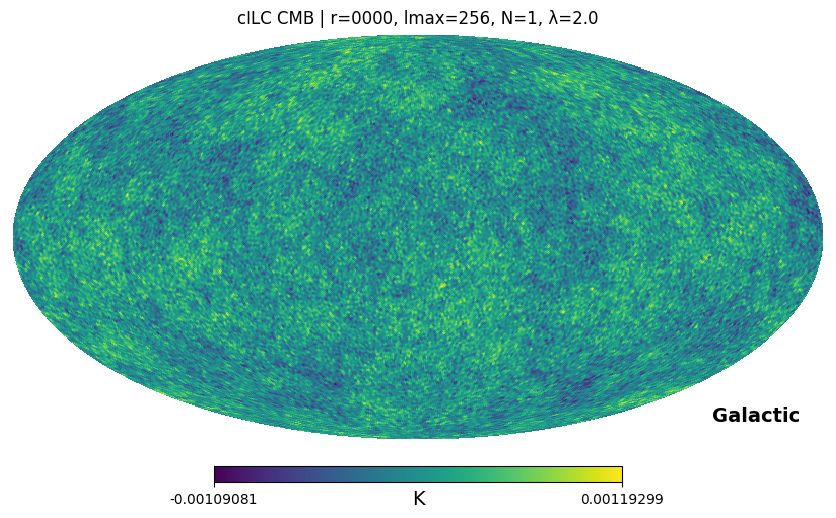

FINAL CHECK  F^T w == f  -> True


In [8]:
pipe.F_source = "theory"  # "empirical" or "theory"
pipe.F_kwargs = {
    "base_dir": os.path.join(pipe.directory, "cmb_realisations"),
    "frequencies": pipe.frequencies,
    "realization": pipe.start_realisation,
    "normalize": True,
    "mask_path": "",
    "file_templates": {
        "cmb": "cmb_r{realisation:04d}.fits",
        "sync": "sync_f{frequency}.fits",
        "tsz":  "tsz_f{frequency}.fits",
    },
}

pipe.step_ilc()

still adapting the 'empirical'

In [ ]:
pipe.F_source = "empirical"  # "empirical" or "theory"
pipe.F_kwargs = {
    "base_dir": os.path.join(pipe.directory, "cmb_realisations"),
    "frequencies": pipe.frequencies,
    "realization": pipe.start_realisation,
    "normalize": True,
    "mask_path": "",
    "file_templates": {
        "cmb": "cmb_r{realisation:04d}.fits",
        "sync": "sync_f{frequency}.fits",
        "tsz":  "tsz_f{frequency}.fits",
    },
}

pipe.step_ilc()

In [9]:
import os, glob
import numpy as np

lmax = 128
# --- build the saved filename exactly like the pipeline does ---
extract_comp = pipe.ilc_components[0]         # e.g. "cmb"
component    = pipe.wavelet_components[0]     # e.g. "cfn"
freq_tag     = "_".join(map(str, pipe.frequencies))
realisation  = int(pipe.start_realisation)
lmax         = int(pipe.lmax)
lam_str      = str(getattr(pipe, "lam", 2.0)) # filenames use string "2.0"

base = os.path.join(pipe.directory, "SILC", "ilc_synthesised_maps")
path = os.path.join(
    base,
    f"{extract_comp}_from-{component}_f{freq_tag}_r{realisation:04d}_lmax{lmax}_lam{lam_str}.npy"
)

# fallback: if lam string differs (e.g. "2" vs "2.0"), try a glob
if not os.path.exists(path):
    cand = glob.glob(os.path.join(
        base,
        f"{extract_comp}_from-{component}_f{freq_tag}_r{realisation:04d}_lmax{lmax}_lam*.npy"
    ))
    if not cand:
        raise FileNotFoundError(f"ILC synth file not found:\n{path}")
    path = sorted(cand)[-1]
    print("Using closest match:", os.path.basename(path))

# --- load and compute mean ---
arr = np.load(path, mmap_mode="r")
arr = np.real(np.squeeze(arr))   # handle (1,H,W) and complex dtype
mean_val = float(np.nanmean(arr))

print("ILC synth file:", path)
print("Mean(ILC synth) =", mean_val)


ILC synth file: /Scratch/agnes/data/SILC/ilc_synthesised_maps/cmb_from-cfn_f030_044_070_100_143_217_353_545_857_r0000_lmax256_lam2.0.npy
Mean(ILC synth) = 0.00010103907062345743


! Check this (should be around 0)

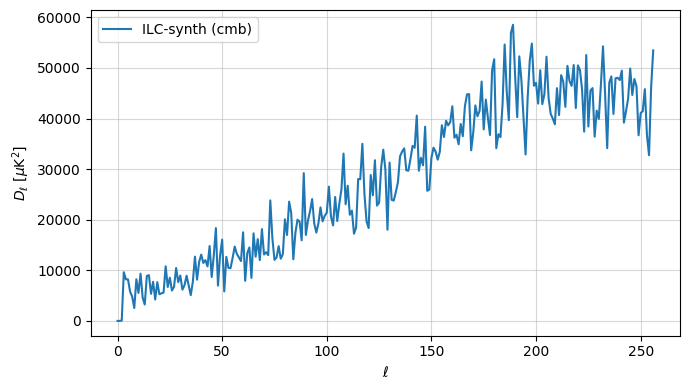

In [10]:
ell, cl = pipe.step_power_spec(
    unit="K",
    source="ilc_synth",
    component="cfn",                  
    extract_comp="cmb",
    frequencies=pipe.frequencies,      
    realisation=0,
    lmax=256,                          
    lam=2.0,                      
)

Checking Process: (it is bit messy right now)

[Per-band calibration] median R_ell = D_ell^ILC / D_ell^theory w ℓ∈[10,247] -> 7.820  (want ~1)
[After mono+dipole removal] median R_ell over ℓ∈[10,247] -> 7.820
[Scaling band] file: /Scratch/agnes/data/wavelet_transforms/scaling_coeffs/cfn_scaling_f030_r00000_lmax256_lam2.0.npy
  exists: True
  shape: (1, 1), min/max/mean: 9.267e-05+0.000e+00j/9.267e-05+0.000e+00j/9.267e-05+0.000e+00j


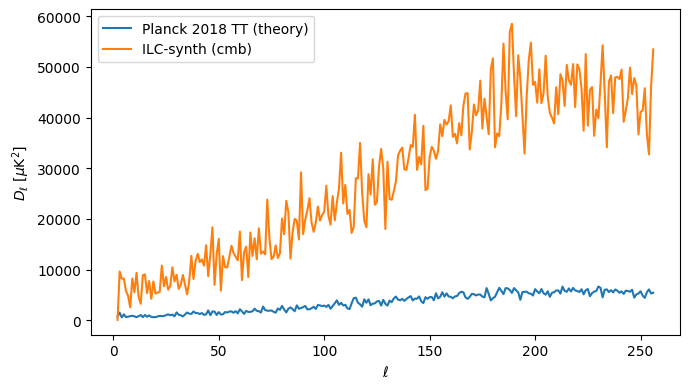

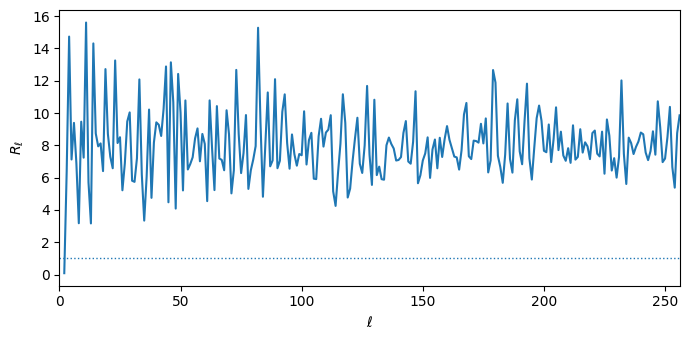

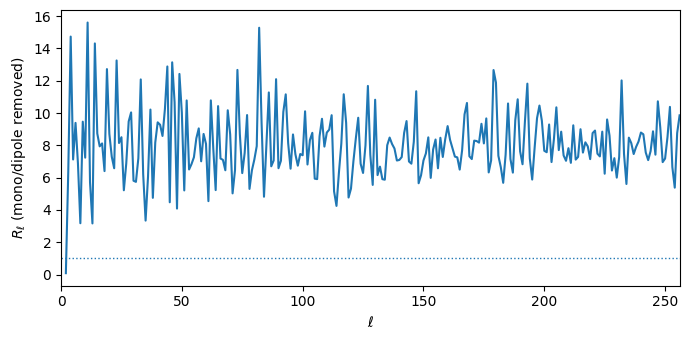

N_directions: 1 lmax: 256 lam: 2.0


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import s2fft 

# --- 0) Config from  pipeline object ---
r        = pipe.start_realisation
lmax_use = pipe.lmax
lam_str  = pipe.lam_str
freqs    = pipe.frequencies
comp_in  = pipe.wavelet_components[0] if pipe.wavelet_components else "cfn"
tgt      = pipe.ilc_components[0] if pipe.ilc_components else "cmb"

# --- 1) Theory D_ell (µK^2) ---
spec_path = os.path.join(pipe.directory, "cmb_spectrum.txt")
theory = np.loadtxt(spec_path)
ell_th = theory[:, 0].astype(int)
Dl_th  = theory[:, 1].astype(float)

# --- 2) Get ILC-synth alm via converter ---
ft   = FileTemplates(pipe.directory).file_templates
conv = MapAlmConverter(ft)
out  = conv.to_alm(
    component=comp_in, source="ilc_synth",
    extract_comp=tgt, frequencies=freqs,
    realisation=r, lmax=lmax_use, lam=lam_str,
)

# --- 3) Cl from ILC alms (K^2) -> D_ell (µK^2) ---
if out["format"] == "mw":
    ell_ilc, cl_ilc = PowerSpectrumTT.from_mw_alm(np.asarray(out["alm"]))
else:
    ell_ilc, cl_ilc = PowerSpectrumTT.from_healpy_alm(out["alm"])

Dl_ilc = PowerSpectrumTT.cl_to_Dl(ell_ilc, cl_ilc, input_unit="K")  # maps→alm→Cl are in K^2

# Align lengths
L   = min(Dl_ilc.size, Dl_th.size)
lax = np.arange(L)
rat = Dl_ilc[:L] / Dl_th[:L]

# Choose a mid-ℓ band for calibration diagnostics
lo   = max(10, 2)               # avoid very low-ℓ
hi   = min(L-10, L-1)
mid  = (lax >= lo) & (lax <= hi)
medR = float(np.nanmedian(rat[mid]))
print(f"[Per-band calibration] median R_ell = D_ell^ILC / D_ell^theory w ℓ∈[{lo},{hi}] -> {medR:.3f}  (want ~1)")

# --- 4) Remove mono/dipole from ILC map and re-check low-ℓ ---
# Build a HEALPix alm for map synthesis if needed
if out["format"] == "mw":

    hp_alm = SamplingConverters.mw_alm_2_hp_alm(out["alm"], lmax=out["lmax"])
else:
    hp_alm = out["alm"]

# pick an nside approximately matching your analysis
nside_guess = 2048 if (3*2048-1) >= out["lmax"] else 1024
m_ilc = hp.alm2map(hp_alm, nside=nside_guess, lmax=out["lmax"], verbose=False)

# SIMPLER: one call; returns 3 values (map, fitted monopole, fitted dipole vector)
m_ilc, mono_fit, dip_vec = hp.remove_dipole(m_ilc, fitval=True)

# recompute Cl/Dl after mono+dipole removal
cl0 = hp.alm2cl(hp.map2alm(m_ilc, lmax=out["lmax"], iter=0))
Dl0 = PowerSpectrumTT.cl_to_Dl(np.arange(cl0.size), cl0, input_unit="K")

# align lengths safely for the "after" ratio
L0   = min(Dl0.size, Dl_th.size)
lax0 = np.arange(L0)
rat0 = Dl0[:L0] / Dl_th[:L0]
lo0  = max(10, 2)
hi0  = min(L0-10, L0-1)
mid0 = (lax0 >= lo0) & (lax0 <= hi0)
medR0 = float(np.nanmedian(rat0[mid0]))
print(f"[After mono+dipole removal] median R_ell over ℓ∈[{lo0},{hi0}] -> {medR0:.3f}")
# print("monopole(K):", mono_fit, "dipole_vec(K):", dip_vec)

# --- 5) Scaling-band presence/health check ---
fk = "f_scal" if "f_scal" in ft else ("scaling_coeffs" if "scaling_coeffs" in ft else None)
if fk:
    fmt = ft[fk]
    try:
        path_scal = fmt.format(
            comp=comp_in,
            frequency=(freqs[0] if isinstance(freqs, (list, tuple)) else (freqs if freqs is not None else "")),
            realisation=int(r), lmax=int(lmax_use), lam=str(lam_str),
        )
    except KeyError:
        path_scal = fmt.format(comp=comp_in, realisation=int(r), lmax=int(lmax_use), lam=str(lam_str))

    exists = os.path.exists(path_scal)
    print(f"[Scaling band] file: {path_scal}\n  exists: {exists}")
    if exists:
        f_scal = np.load(path_scal)
        print(f"  shape: {f_scal.shape}, min/max/mean: {f_scal.min():.3e}/{f_scal.max():.3e}/{f_scal.mean():.3e}")
else:
    print("[Scaling band] No scaling-coeff template key ('f_scal' or 'scaling_coeffs') found in FileTemplates.")

# --- 6) Plots: overlay + ratio ---
plt.figure(figsize=(7,4))
plt.plot(lax[2:], Dl_th[:L][2:], label="Planck 2018 TT (theory)")
plt.plot(lax[2:], Dl_ilc[:L][2:], label=f"ILC-synth ({tgt})")
plt.xlabel(r"$\ell$"); plt.ylabel(r"$D_\ell\ [\mu\mathrm{K}^2]$"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.5))
plt.plot(lax[2:], rat[2:], label="ratio ILC/theory")
plt.axhline(1.0, ls=":", lw=1)
plt.xlim(0, L-1)
plt.xlabel(r"$\ell$"); plt.ylabel(r"$R_\ell$")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.5))
plt.plot(lax0[2:], rat0[2:], label="ratio after mono+dipole removal")
plt.axhline(1.0, ls=":", lw=1)
plt.xlim(0, L0-1)
plt.xlabel(r"$\ell$"); plt.ylabel(r"$R_\ell$ (mono/dipole removed)")
plt.tight_layout(); plt.show()

# --- 7) Directionality metadata (informational) ---
try:
    print("N_directions:", pipe.N_directions, "lmax:", pipe.lmax, "lam:", pipe.lam_str)
except Exception:
    pass

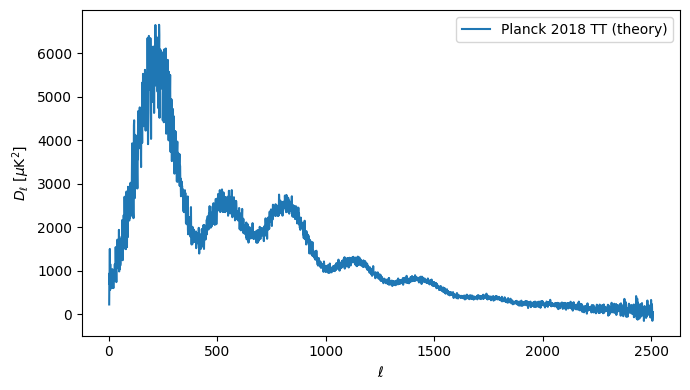

In [12]:
# Plot Planck 2018 best-fit TT theory (D_ell in µK^2) from cmb_spectrum.txt

import os
import numpy as np
import matplotlib.pyplot as plt

# 1) Point to the folder that contains cmb_spectrum.txt

data_dir = pipe.directory

path = os.path.join(data_dir, "cmb_spectrum.txt")

# 2) Load (format: ell, Dl, 0, 0)
data = np.loadtxt(path)
ell = data[:, 0].astype(int)
Dl  = data[:, 1].astype(float)  # µK^2

# 3) Plot
plt.figure(figsize=(7, 4))
plt.plot(ell, Dl, '-', label="Planck 2018 TT (theory)")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell\ [\mu\mathrm{K}^2]$")
plt.legend()
plt.tight_layout()
plt.show()


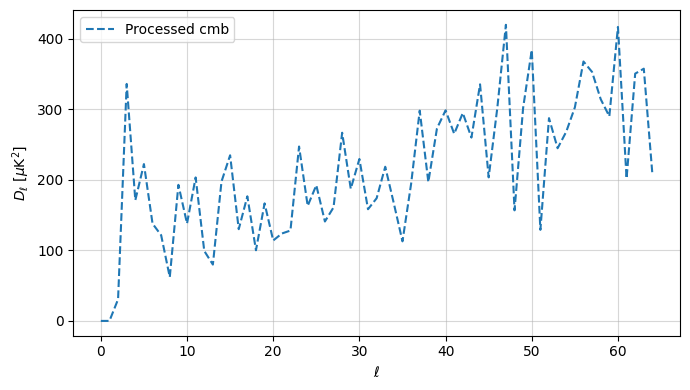

[ratio] ℓ-band = [2, 64], N=63 valid
[ratio] median R_ell = D_proc / D_input = 0.194


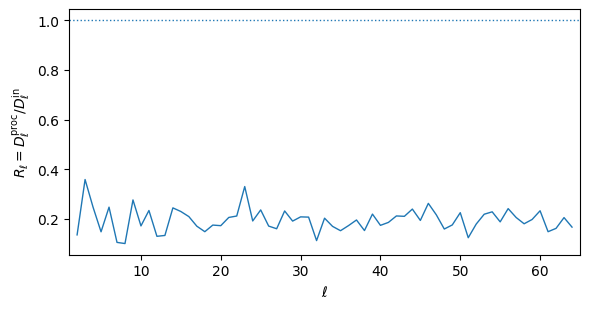

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

def ratio_processed_vs_input_2_64(pipe, component="cmb", realisation=0, theory_path=None):
    """
    Compute R_ell = Dl_processed / Dl_input for ell in [2, 64].

    processed: pipe.step_power_spec(unit="K", source="processed", ...) -> (ell, Cl[K^2])
    input/theory file: cmb_spectrum.txt with columns [ell, Dl(µK^2), ...]
    """
    # --- 1) processed spectrum (Cl in K^2) -> Dl in µK^2
    ell_p, Cl_p = pipe.step_power_spec(
        unit="K",
        source="processed",
        component=component,
        realisation=realisation,
        lmax=64,
    )
    ell_p = ell_p.astype(int)
    Dl_p = np.zeros_like(Cl_p, dtype=float)
    m = ell_p >= 2
    Dl_p[m] = ell_p[m] * (ell_p[m] + 1) / (2 * np.pi) * Cl_p[m] * 1e12  # K^2 -> µK^2

    # --- 2) load theory Dl (µK^2) from file (ignore extra columns)
    if theory_path is None:
        theory_path = os.path.join(pipe.directory, "cmb_spectrum.txt")
    arr = np.loadtxt(theory_path)  # expects at least 2 columns
    ell_th = arr[:, 0].astype(int)
    Dl_th  = arr[:, 1].astype(float)  # already µK^2

    # --- 3) build common ℓ list in [2,64]
    Dl_p_map  = {int(L): v for L, v in zip(ell_p,  Dl_p)}
    Dl_th_map = {int(L): v for L, v in zip(ell_th, Dl_th)}
    ell_common = np.array([L for L in range(2, 65) if L in Dl_p_map and L in Dl_th_map], dtype=int)
    if ell_common.size == 0:
        raise RuntimeError("No overlapping ℓ between processed and theory in [2,64].")

    Dl_p_band  = np.array([Dl_p_map[L]  for L in ell_common], dtype=float)
    Dl_th_band = np.array([Dl_th_map[L] for L in ell_common], dtype=float)

    # --- 4) ratio (safe)
    ratio = np.full_like(Dl_p_band, np.nan, dtype=float)
    valid = Dl_th_band > 0
    ratio[valid] = Dl_p_band[valid] / Dl_th_band[valid]

    # --- 5) report + plot
    medR = float(np.nanmedian(ratio))
    print(f"[ratio] ℓ-band = [{ell_common.min()}, {ell_common.max()}], N={valid.sum()} valid")
    print(f"[ratio] median R_ell = D_proc / D_input = {medR:.3f}")

    plt.figure(figsize=(6,3.2))
    plt.plot(ell_common, ratio, lw=1)
    plt.axhline(1.0, ls=":", lw=1)
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$R_\ell = D_\ell^{\rm proc}/D_\ell^{\rm in}$")
    plt.xlim(1, 65)
    plt.tight_layout(); plt.show()

    return ell_common, ratio, medR

# --- run it ---
ell_band, R_band, medR = ratio_processed_vs_input_2_64(
    pipe,
    component="cmb",
    realisation=0,
    theory_path=os.path.join(pipe.directory, "cmb_spectrum.txt"),
)


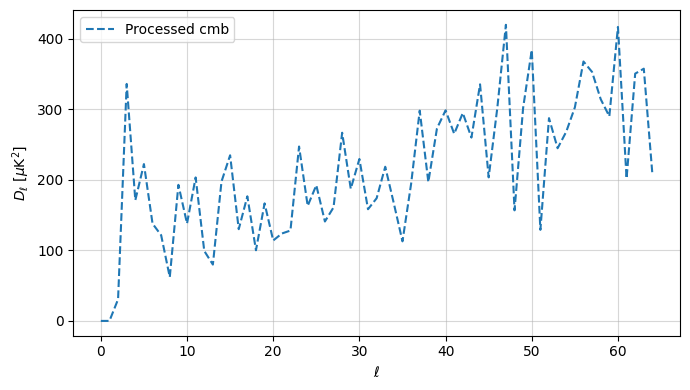

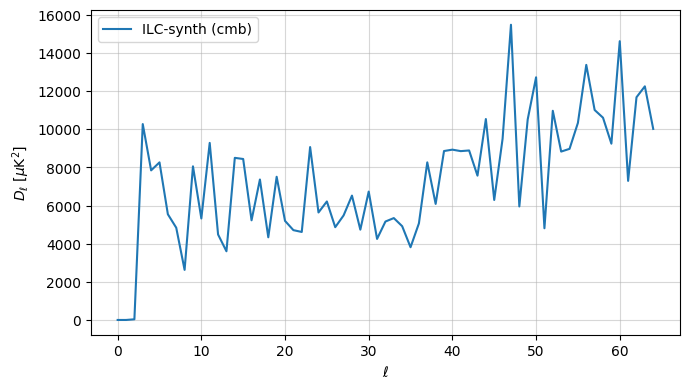

[processed / ILC_synth] ℓ-band = [2, 64], N=63 valid
[processed / ILC_synth] median R_ell = 0.029


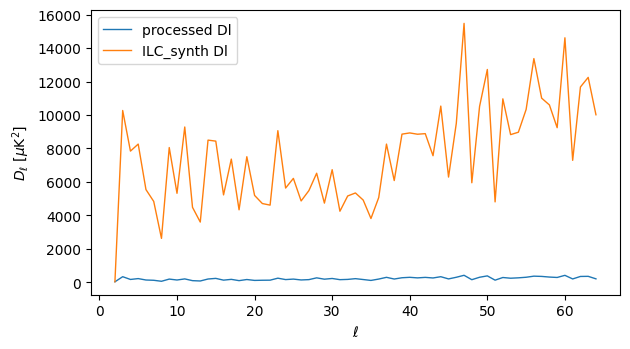

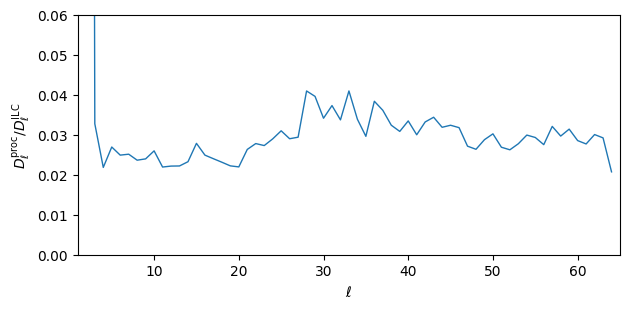

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def cl_to_Dl(ell, Cl):
    Dl = np.zeros_like(Cl, dtype=float)
    m = ell >= 2
    Dl[m] = ell[m]*(ell[m]+1)/(2*np.pi) * Cl[m] * 1e12  # K^2 -> µK^2
    return Dl

def ratio_processed_vs_ilc_synth(pipe, realisation=0, lmax=64, lam=2.0):
    # --- processed spectrum (Cl[K^2]) -> Dl[µK^2]
    ell_p, Cl_p = pipe.step_power_spec(
        unit="K",
        source="processed",
        component="cmb",          # processed CMB component
        realisation=realisation,
        lmax=lmax,
    )
    ell_p = ell_p.astype(int)
    Dl_p = cl_to_Dl(ell_p, Cl_p)

    # --- ILC_synth spectrum (Cl[K^2]) -> Dl[µK^2]
    ell_i, Cl_i = pipe.step_power_spec(
        unit="K",
        source="ilc_synth",
        component="cfn",          # CFN cube as input
        extract_comp="cmb",       # extract the CMB
        frequencies=pipe.frequencies,
        realisation=realisation,
        lmax=lmax,
        lam=lam,
    )
    ell_i = ell_i.astype(int)
    Dl_i = cl_to_Dl(ell_i, Cl_i)

    # --- common ℓ in [2, lmax]
    LMIN, LMAX = 2, int(lmax)
    common = np.intersect1d(ell_p, ell_i)
    ell_band = common[(common >= LMIN) & (common <= LMAX)]
    if ell_band.size == 0:
        raise RuntimeError("No overlapping ℓ in [2, lmax] between processed and ILC_synth.")

    # index maps
    idx_p = {int(L): k for k, L in enumerate(ell_p)}
    idx_i = {int(L): k for k, L in enumerate(ell_i)}

    Dl_p_band = np.array([Dl_p[idx_p[L]] for L in ell_band], dtype=float)
    Dl_i_band = np.array([Dl_i[idx_i[L]] for L in ell_band], dtype=float)

    # --- ratio (safe)
    ratio = np.full_like(Dl_p_band, np.nan, dtype=float)
    valid = Dl_i_band > 0
    ratio[valid] = Dl_p_band[valid] / Dl_i_band[valid]

    # --- report + plots
    medR = float(np.nanmedian(ratio))
    print(f"[processed / ILC_synth] ℓ-band = [{ell_band.min()}, {ell_band.max()}], "
          f"N={int(np.isfinite(ratio).sum())} valid")
    print(f"[processed / ILC_synth] median R_ell = {medR:.3f}")

    # Optional: overlay spectra
    plt.figure(figsize=(6.4,3.6))
    plt.plot(ell_band, Dl_p_band, label="processed Dl", lw=1)
    plt.plot(ell_band, Dl_i_band, label="ILC_synth Dl", lw=1)
    plt.xlabel(r"$\ell$"); plt.ylabel(r"$D_\ell\ [\mu \mathrm{K}^2]$")
    plt.legend(); plt.tight_layout(); plt.show()

    # Ratio plot
    plt.figure(figsize=(6.4,3.2))
    plt.plot(ell_band, ratio, lw=1)
    plt.axhline(1.0, ls=":", lw=1)
    plt.xlabel(r"$\ell$"); plt.ylabel(r"$D_\ell^{\rm proc} / D_\ell^{\rm ILC}$")
    plt.xlim(LMIN-1, LMAX+1)
    plt.ylim(0,0.06)
    plt.tight_layout(); plt.show()

    return ell_band, ratio, medR

# --- run it ---
ell_band, R_band, medR = ratio_processed_vs_ilc_synth(pipe, realisation=0, lmax=64, lam=2.0)


this is not right, could it be aliasing due to low lmax? try high lmax 

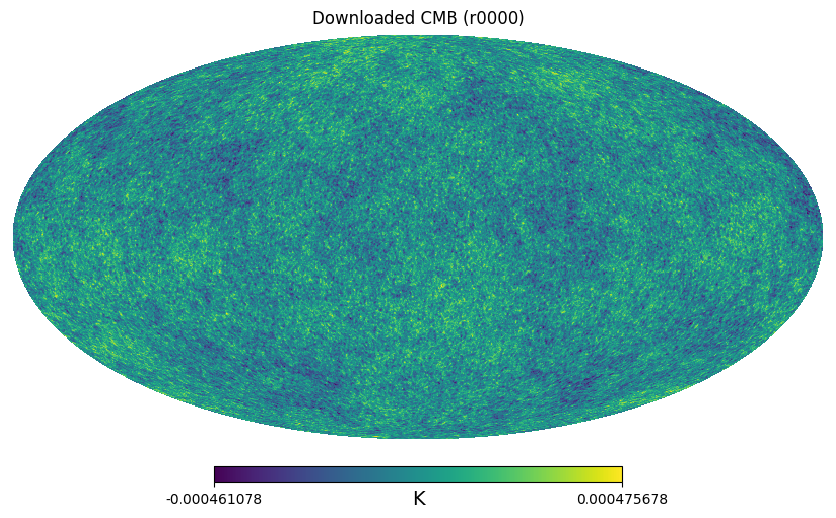

Shown: /Scratch/agnes/data/CMB_realisations/cmb_r0000.fits


In [15]:
import os
import healpy as hp
import matplotlib.pyplot as plt

path = FileTemplates(pipe.directory).file_templates["cmb"].format(realisation=0)

m = hp.read_map(path, field=0, dtype=float)  # I (temperature) only
hp.mollview(m, title="Downloaded CMB (r0000)", unit="K")
plt.show()

print("Shown:", path)

In [16]:
import numpy as np
import healpy as hp

# Use valid pixels
valid = np.isfinite(m) & (m != hp.UNSEEN)
mean_K = float(np.mean(m[valid]))
print(f"Mean = {mean_K:.6e} K  ({mean_K*1e6:.2f} µK);  used {valid.sum()}/{m.size} pixels")

# (Optional) cross-check via a_00:
a00 = hp.map2alm(m, lmax=0, iter=0)[0].real
mean_from_a00 = a00 / np.sqrt(4*np.pi)
print(f"a_00-derived mean = {mean_from_a00:.6e} K  (Δ={mean_K-mean_from_a00:+.3e} K)")


Mean = 8.525747e-13 K  (0.00 µK);  used 50331648/50331648 pixels
a_00-derived mean = 8.525747e-13 K  (Δ=+4.420e-21 K)
